In [156]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [157]:
# df = pd.read_csv('../../data/01-analysis_data/00-fomc_transcript_dataframes/00-transcripts/FOMC20160921.csv', )

# df = pd.read_csv('../../data/01-analysis_data/00-fomc_transcript_dataframes/00-transcripts/FOMC20160921.csv',sep='\t')
# df

In [158]:
# with open('../../data/01-analysis_data/00-fomc_transcript_dataframes/00-transcripts/FOMC20160921.csv') as f:
#     for i, line in enumerate(f):
#         if i >= 20 and i <= 25:
#             print(f"Line {i}: {line.strip()}")


In [159]:
spy_df = pd.read_csv('../data/sp500_raw_index_1976-01-01_to_2023-12-31_1D.csv')
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
spy_df['Log Return'] = np.log(spy_df['Adj Close']).diff()
spy_df.set_index('Date', inplace=True)
# from utils.sentiment_scoring import score_sentiment
# score_sentiment()
df = pd.read_csv('../data/meeting_time_series.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Future Economic Growth,Future Financial Stability,Future Inflation,Future Labor Market,Future Monetary Policy
0,1976-03-29,1.000000,0.333333,NaN,NaN,0.882353
1,1976-04-20,0.739130,0.600000,0.500000,1.000000,1.000000
2,1976-05-18,0.826087,0.714286,-0.333333,0.000000,0.500000
3,1976-06-22,0.454545,-1.000000,NaN,NaN,0.600000
4,1976-07-20,0.379310,0.454545,1.000000,0.333333,1.000000


In [160]:
# spy_df.tail()

<Axes: xlabel='Date'>

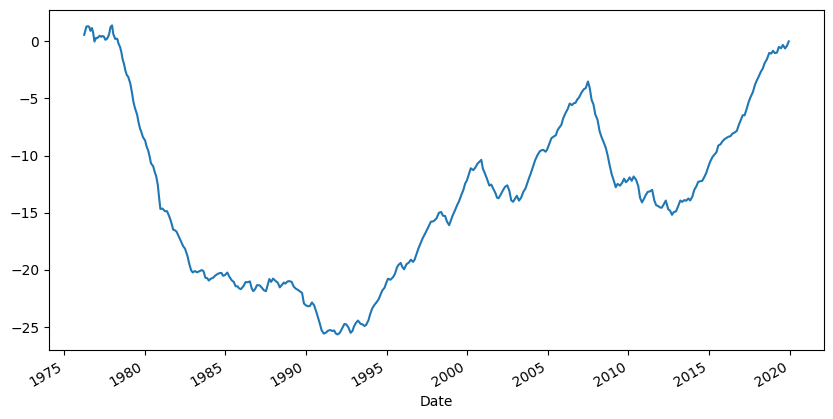

In [161]:
df['Demeaned Sentiment'] = (df['Future Economic Growth'] - df['Future Economic Growth'].mean())
plt.figure(figsize=(10, 5))
df.set_index('Date')['Demeaned Sentiment'].cumsum().plot()

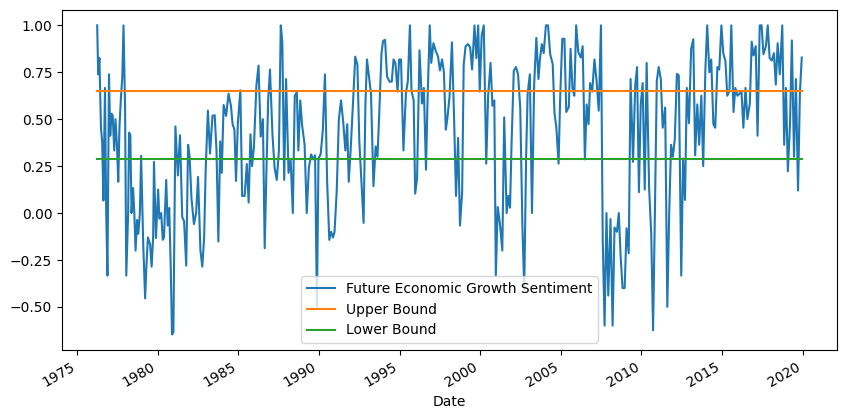

In [162]:
# Get the upper, lower, bounds (terciles) of the demeaned sentiment
# df['Sentiment Upper Bound'] = df['Demeaned Sentiment'].expanding().quantile(0.66)
df['Sentiment Upper Bound'] = df['Future Economic Growth'].quantile(0.66)

# df['Sentiment Lower Bound'] = df['Demeaned Sentiment'].expanding().quantile(0.33)
df['Sentiment Lower Bound'] = df['Future Economic Growth'].quantile(0.33)

plt.figure(figsize=(10, 5))
df.set_index('Date')['Future Economic Growth'].plot()
df.set_index('Date')['Sentiment Upper Bound'].plot()
df.set_index('Date')['Sentiment Lower Bound'].plot()
plt.legend(['Future Economic Growth Sentiment', 'Upper Bound', 'Lower Bound'])
df['Sentiment_Flag'] = np.where(df['Future Economic Growth'] > df['Sentiment Upper Bound'], 1, np.where(df['Future Economic Growth'] < df['Sentiment Lower Bound'], -1, 0))
#THis is an option.
# df['Sentiment Flag'] = df['Sentiment Flag'].shift(1)

([<matplotlib.axis.XTick at 0x16b92be80>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')])

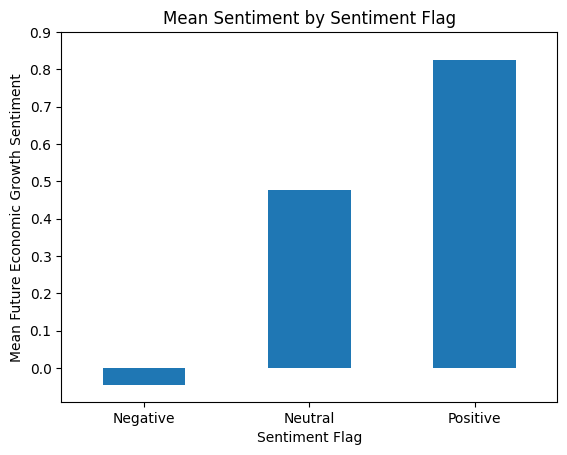

In [163]:
df.groupby('Sentiment_Flag')['Future Economic Growth'].mean().plot(kind='bar')
plt.title('Mean Sentiment by Sentiment Flag')
plt.xlabel('Sentiment Flag')
plt.ylabel('Mean Future Economic Growth Sentiment')
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=0)
# plt.savefig('../../data/01-analysis_data/00-fomc_transcript_dataframes/04-sentiment_metrics/meeting_sentiment_flag.png')

In [164]:
start_window = -45
return_window = 45
for i in range(start_window, return_window + 1):
    spy_df[f'Log Return t={i}'] = spy_df['Log Return'].shift(-i)
spy_df = spy_df.dropna()
# spy_df[f'Log Return t={start_window}'] = 0
for t in range(start_window, return_window + 1):
    spy_df[f'Cumulative Log Return {t}'] = spy_df.loc[:, f'Log Return t={start_window}':f'Log Return t={t}'].sum(axis=1)

for i in range(start_window, return_window + 1):
    spy_df = spy_df.drop(columns=[f'Log Return t={i}'])


In [165]:
x = pd.merge_asof(df, spy_df, on='Date', direction='backward', suffixes=('', '_y'), allow_exact_matches=False)
# # Demean the cumulative log returns with an expanding mean(min_window=8)
for t in range(start_window, return_window + 1):
    x[f'Cumulative Log Return {t}'] = (x[f'Cumulative Log Return {t}'] - x[f'Cumulative Log Return {t}'].expanding().mean())

# for t in range(start_window, return_window + 1):
#     x[f'Cumulative Log Return {t}'] = x[f'Cumulative Log Return {t}'] / x[f'Cumulative Log Return {return_window}']
x = x.dropna()
x.head()

,Date,Future Economic Growth,Future Financial Stability,Future Inflation,Future Labor Market,Future Monetary Policy,Demeaned Sentiment,Sentiment Upper Bound,Sentiment Lower Bound,Sentiment_Flag,...,Cumulative Log Return 36,Cumulative Log Return 37,Cumulative Log Return 38,Cumulative Log Return 39,Cumulative Log Return 40,Cumulative Log Return 41,Cumulative Log Return 42,Cumulative Log Return 43,Cumulative Log Return 44,Cumulative Log Return 45
1,1976-04-20,0.739130,0.600000,0.500000,1.000000,1.000000,0.315237,0.652174,0.285714,1,...,-0.025314,-0.020784,-0.018036,-0.009318,-0.002659,-0.000207,0.008329,0.008851,0.007342,0.005093
2,1976-05-18,0.826087,0.714286,-0.333333,0.000000,0.500000,0.402194,0.652174,0.285714,1,...,0.010227,0.014115,0.012719,0.010312,0.019727,0.013022,0.005034,0.001929,-0.006064,-0.001722
4,1976-07-20,0.379310,0.454545,1.000000,0.333333,1.000000,-0.044583,0.652174,0.285714,0,...,0.003329,-0.004515,-0.008733,-0.011974,-0.011309,-0.008229,0.000523,0.009914,0.009586,0.024253
5,1976-08-17,0.066667,0.333333,1.000000,1.000000,0.666667,-0.357227,0.652174,0.285714,-1,...,0.013426,0.015788,0.002356,-0.004983,-0.008460,0.002384,-0.009419,-0.008670,-0.004476,-0.004170
6,1976-09-21,0.666667,0.714286,1.000000,1.000000,1.000000,0.242773,0.652174,0.285714,1,...,-0.071071,-0.066608,-0.073418,-0.066303,-0.061055,-0.057956,-0.046511,-0.045871,-0.041659,-0.046507


In [166]:
spts = [x for x in x.columns if 'Cumulative Log Return' in x]
# Renaeme the columns to remove the 'Cumulative Log Return' prefix
x = x.rename(columns={col: col.replace('Cumulative Log Return ', '') for col in spts})
spts = [n.replace('Cumulative Log Return ', '') for n in spts]
zero_value = x.groupby('Sentiment_Flag')[['0']].mean()

y = x.groupby('Sentiment_Flag')[spts].mean()


In [167]:
y = y.subtract(zero_value['0'], axis=0)

<Figure size 1000x500 with 0 Axes>

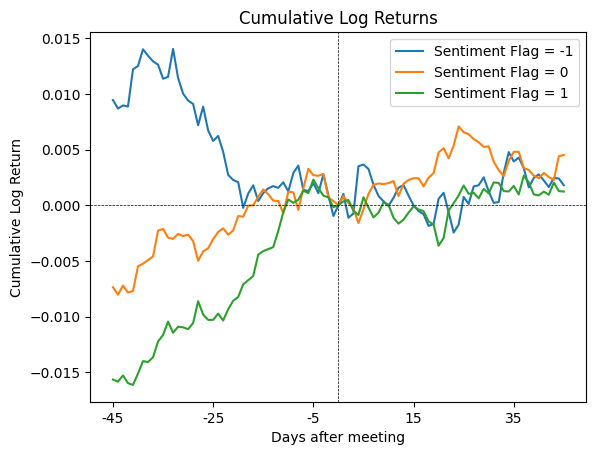

In [168]:
#PLot the cumulative log returns, a line for each row
plt.figure(figsize=(10, 5))
y.T.plot()
plt.title('Cumulative Log Returns')
plt.xlabel('Days after meeting')
plt.ylabel('Cumulative Log Return')
plt.legend(['Sentiment Flag = -1', 'Sentiment Flag = 0', 'Sentiment Flag = 1'])
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(45, color='black', linewidth=0.5, linestyle='--')
# plt.savefig('../../data/01-analysis_data/00-fomc_transcript_dataframes/04-sentiment_metrics/cumulative_log_return_sentiment_flag.png', dpi=300, bbox_inches='tight')
# TODO: Am I counting neutral in the sentiment??
plt.show()

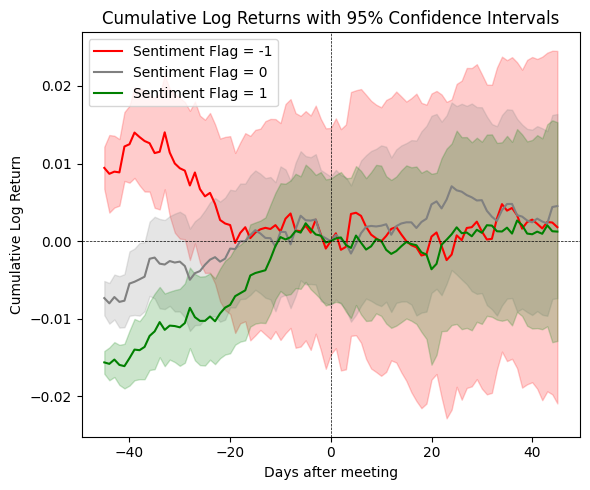

In [169]:
# Mean cumulative log return
y = x.groupby('Sentiment_Flag')[spts].mean()
y = y.subtract(zero_value['0'], axis=0)

# Standard deviation
y_std = x.groupby('Sentiment_Flag')[spts].std()

# Sample size per group
group_counts = x.groupby('Sentiment_Flag').size()

# 95% Confidence Interval calculation
ci_95 = {}
for flag in [-1, 0, 1]:
    ci_95[flag] = 1.96 * y_std.loc[flag] / group_counts[flag]**0.5

# Plotting
plt.figure(figsize=(6, 5))
colors = { -1: 'red', 0: 'gray', 1: 'green' }

for flag in [-1, 0, 1]:
    mean_vals = y.loc[flag].astype(float)
    ci_vals = ci_95[flag].astype(float)
    
    x_vals = mean_vals.index.astype(int)
    
    plt.plot(x_vals, mean_vals.values, label=f'Sentiment Flag = {flag}', color=colors[flag])
    plt.fill_between(x_vals,
                     mean_vals - ci_vals,
                     mean_vals + ci_vals,
                     color=colors[flag],
                     alpha=0.2)

plt.title('Cumulative Log Returns with 95% Confidence Intervals')
plt.xlabel('Days after meeting')
plt.ylabel('Cumulative Log Return')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [170]:
# x.loc[x['Sentiment_Flag'] == -1, spts] = -1 * x.loc[x['Sentiment_Flag'] == -1, spts]

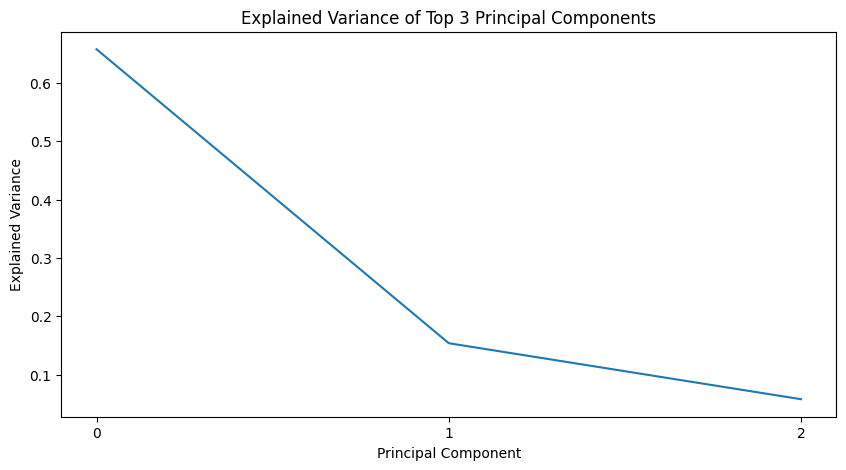

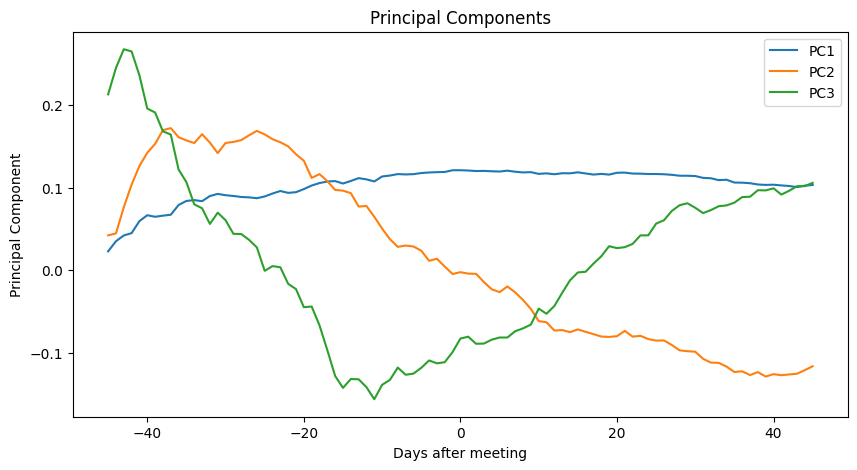

In [171]:
# DO PCA on the spts
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
pca = PCA()

pipe = Pipeline([('scaler', scaler), ('pca', pca)])
pipe.fit(x[x['Sentiment_Flag']==0][spts])

# plot the top 3 components
plt.figure(figsize=(10, 5))
plt.plot(pipe.named_steps['pca'].explained_variance_ratio_[:3])
plt.title('Explained Variance of Top 3 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks([0, 1, 2])

# PLot the principal components. Subtract 45 from x-axis to center the plot around 0
n_days = len(pipe.named_steps['pca'].components_[0])
x_values = np.arange(n_days) - 45

plt.figure(figsize=(10, 5))
plt.plot(x_values, pipe.named_steps['pca'].components_[:3].T)
plt.title('Principal Components')
plt.xlabel('Days after meeting')
plt.ylabel('Principal Component')
plt.legend(['PC1', 'PC2', 'PC3'])
plt.show()

#PC1 is market perfecr pricing, # PC2 is underreaction, PC3 is overreaction

In [172]:
x[spts].head()

,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,...,36,37,38,39,40,41,42,43,44,45
1,-0.001568,-0.010401,-0.015884,-0.008792,0.001692,-0.002872,-0.009009,-0.006996,-0.010200,-0.021624,...,-0.025314,-0.020784,-0.018036,-0.009318,-0.002659,-0.000207,0.008329,0.008851,0.007342,0.005093
2,-0.004370,-0.013434,-0.005489,-0.006521,-0.012582,-0.019283,-0.019306,-0.010662,-0.002922,-0.003783,...,0.010227,0.014115,0.012719,0.010312,0.019727,0.013022,0.005034,0.001929,-0.006064,-0.001722
4,-0.002005,-0.009075,-0.015780,-0.015571,-0.016737,-0.013731,-0.020619,-0.037873,-0.040241,-0.038649,...,0.003329,-0.004515,-0.008733,-0.011974,-0.011309,-0.008229,0.000523,0.009914,0.009586,0.024253
5,0.014597,0.023883,0.016339,0.019618,0.032274,0.029258,0.033752,0.027989,0.023823,0.030754,...,0.013426,0.015788,0.002356,-0.004983,-0.008460,0.002384,-0.009419,-0.008670,-0.004476,-0.004170
6,-0.003365,-0.007309,-0.014343,-0.015340,-0.016924,-0.019678,-0.020029,-0.023157,-0.028473,-0.028002,...,-0.071071,-0.066608,-0.073418,-0.066303,-0.061055,-0.057956,-0.046511,-0.045871,-0.041659,-0.046507


        Date  Future Economic Growth  Sentiment_Flag       PC1       PC2  \
1 1976-04-20                0.739130               1 -3.812276 -0.534061   
2 1976-05-18                0.826087               1 -3.622183 -0.779033   
4 1976-07-20                0.379310               0 -3.478180 -2.554022   
5 1976-08-17                0.066667              -1  4.058833  3.856796   
6 1976-09-21                0.666667               1 -7.560649 -0.090375   

        PC3  
1 -0.812020  
2  0.383933  
4 -2.622913  
5  2.453876  
6 -1.955751  


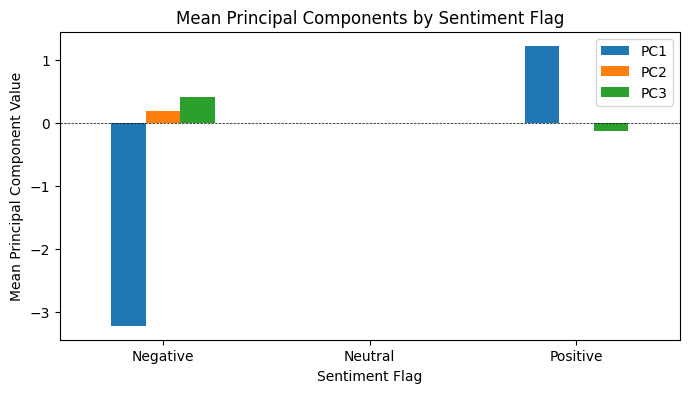

In [173]:
# -----------------
# Create a time-series DataFrame with date, sentiment, and PC1-3

# Perform the transform
pcs = pipe.transform(x[spts])  # shape: (n_rows, n_components)
# Add pcs to x
x['PC1'] = pcs[:, 0]
x['PC2'] = pcs[:, 1]
x['PC3'] = pcs[:, 2]

# Construct a DataFrame of the first 3 PCs alongside "Date" and "Sentiment_Flag"
df_pcs = pd.DataFrame({
    'Date': x['Date'],
    'Future Economic Growth': x['Future Economic Growth'],
    'Sentiment_Flag': x['Sentiment_Flag'],
    'PC1': pcs[:, 0],
    'PC2': pcs[:, 1],
    'PC3': pcs[:, 2],
}, index=x.index)  # keep the same index as x, if desired

print(df_pcs.head())

#PLot Mean PCs by sentiment flag

# Suppose Sentiment_Flag is in {-1, 0, 1}
mapping = { -1: 'Negative', 0: 'Neutral', 1: 'Positive' }

# Compute the mean PCs, grouped by the numeric sentiment
mean_pcs = df_pcs.groupby('Sentiment_Flag')[['PC1', 'PC2', 'PC3']].mean()

# Rename the resulting rows to 'Negative', 'Neutral', 'Positive'
mean_pcs.rename(index=mapping, inplace=True)

# Reindex in the specific order you want
mean_pcs = mean_pcs.reindex(['Negative', 'Neutral', 'Positive'])

# Now do the bar plot
ax = mean_pcs.plot(kind='bar', figsize=(8, 4))
ax.set_title('Mean Principal Components by Sentiment Flag')
ax.set_xlabel('Sentiment Flag')
ax.set_ylabel('Mean Principal Component Value')
ax.legend(['PC1', 'PC2', 'PC3'])
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xticks(rotation=0)
plt.show()


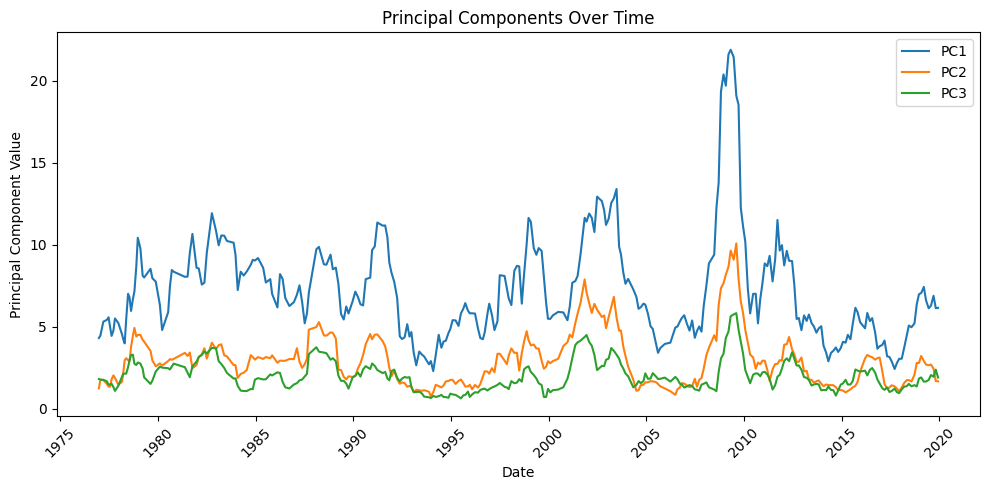

In [174]:
#Timeseries of the PCs
plt.figure(figsize=(10, 5))
plt.plot(df_pcs['Date'], df_pcs['PC1'].abs().rolling(window=8).mean(), label='PC1')
plt.plot(df_pcs['Date'], df_pcs['PC2'].abs().rolling(window=8).mean(), label='PC2')
plt.plot(df_pcs['Date'], df_pcs['PC3'].abs().rolling(window=8).mean(), label='PC3')
plt.title('Principal Components Over Time')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Correlation of PC laodings with macrofactos can tell us which factors drive more information injection.

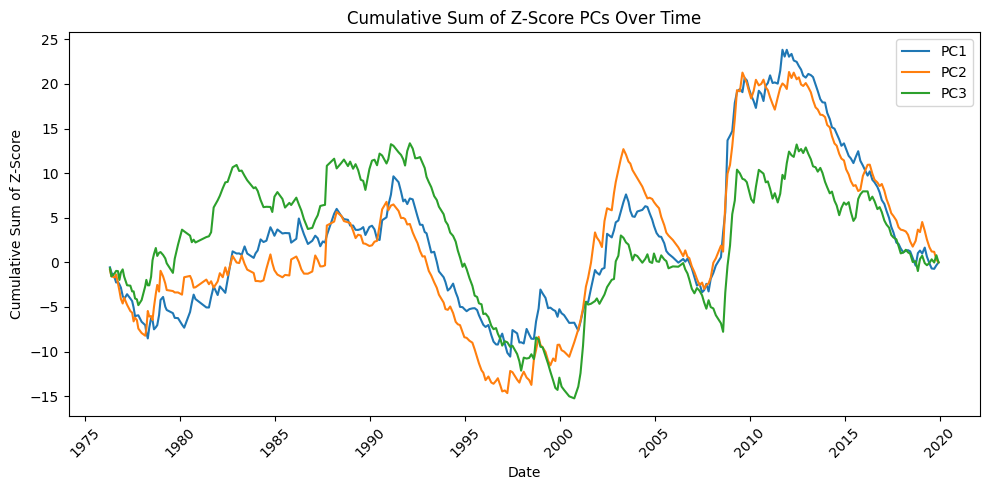

In [175]:
#Z-score the absolute PCs
df_pcs['PC1 Z-Score'] = (df_pcs['PC1'].abs() - df_pcs['PC1'].abs().mean()) / df_pcs['PC1'].abs().std()
df_pcs['PC2 Z-Score'] = (df_pcs['PC2'].abs() - df_pcs['PC2'].abs().mean()) / df_pcs['PC2'].abs().std()
df_pcs['PC3 Z-Score'] = (df_pcs['PC3'].abs() - df_pcs['PC3'].abs().mean()) / df_pcs['PC3'].abs().std()

#Plot the cumsum
plt.figure(figsize=(10, 5))
plt.plot(df_pcs['Date'], df_pcs['PC1 Z-Score'].cumsum(), label='PC1')
plt.plot(df_pcs['Date'], df_pcs['PC2 Z-Score'].cumsum(), label='PC2')
plt.plot(df_pcs['Date'], df_pcs['PC3 Z-Score'].cumsum(), label='PC3')
plt.title('Cumulative Sum of Z-Score PCs Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum of Z-Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


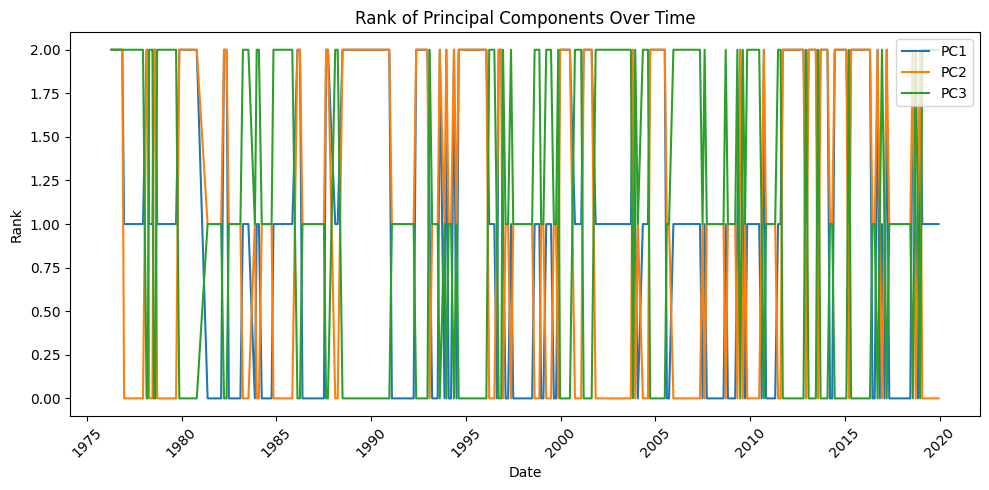

In [176]:
# Crossectionally, which of PC1, PC2, PC3 has a higher z-score (should be ranks 0, 1, or 2)
# I then want to plot this timeseries of ranks of the 3, to see which is highest at any point in time

# Get the ranks of the absolute values of the PCs
df_pcs['PC1 Rank'] = np.where(df_pcs['PC1 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC2 Z-Score'].abs().rolling(window=8).mean(), np.where(df_pcs['PC1 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC3 Z-Score'].abs().rolling(window=8).mean(), 0, 2), np.where(df_pcs['PC2 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC3 Z-Score'].abs().rolling(window=8).mean(), 1, 2))
df_pcs['PC2 Rank'] = np.where(df_pcs['PC2 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC1 Z-Score'].abs().rolling(window=8).mean(), np.where(df_pcs['PC2 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC3 Z-Score'].abs().rolling(window=8).mean(), 0, 2), np.where(df_pcs['PC1 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC3 Z-Score'].abs().rolling(window=8).mean(), 1, 2))
df_pcs['PC3 Rank'] = np.where(df_pcs['PC3 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC1 Z-Score'].abs().rolling(window=8).mean(), np.where(df_pcs['PC3 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC2 Z-Score'].abs().rolling(window=8).mean(), 0, 2), np.where(df_pcs['PC1 Z-Score'].abs().rolling(window=8).mean() > df_pcs['PC2 Z-Score'].abs().rolling(window=8).mean(), 1, 2))

# Get the ranks of the absolute values of the PCs

# plot the ranks
plt.figure(figsize=(10, 5))
plt.plot(df_pcs['Date'], df_pcs['PC1 Rank'], label='PC1')
plt.plot(df_pcs['Date'], df_pcs['PC2 Rank'], label='PC2')
plt.plot(df_pcs['Date'], df_pcs['PC3 Rank'], label='PC3')
plt.title('Rank of Principal Components Over Time')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

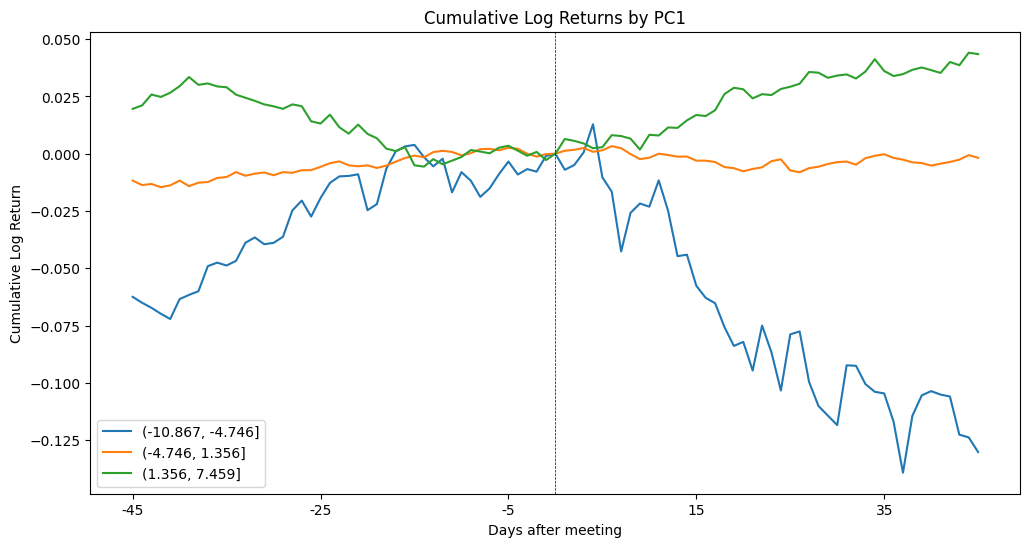

In [177]:
#Group by PC1, plot the event
# Group by PC1 and calculate the mean
# Create bins for PC1
x['PC1_bin'] = pd.cut(x['PC3'], bins=3)
zero_value = x.groupby('PC1_bin')[['0']].median()
y = x.groupby('PC1_bin')[spts].median()
y = y.subtract(zero_value['0'], axis=0)
# Plot the cumulative log returns, a line for each row
y.T.plot(figsize=(12, 6))
plt.title('Cumulative Log Returns by PC1')
plt.xlabel('Days after meeting')
plt.ylabel('Cumulative Log Return')
# Line axvline at 0
plt.axvline(45, color='black', linewidth=0.5, linestyle='--')
# Legend on the RHS
plt.legend()
plt.show()


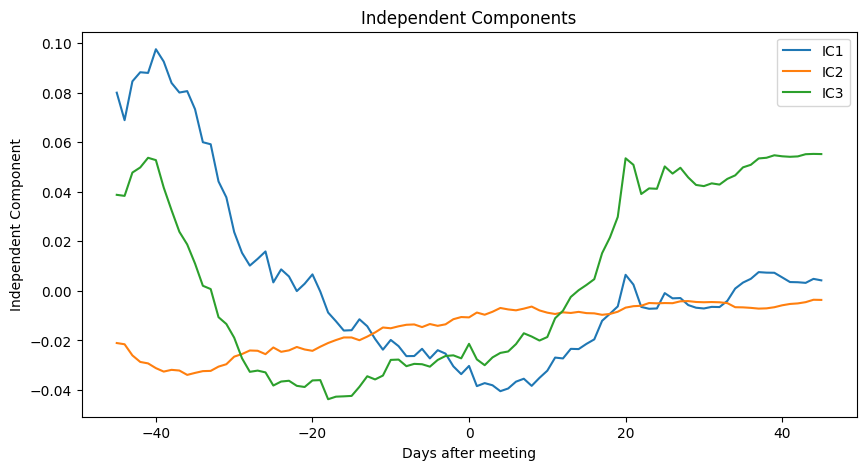

In [178]:
# DO the same but ICA
from sklearn.decomposition import FastICA
# x[spts] = pca.transform(x[spts])
ica = FastICA(n_components=3)
pipe = Pipeline([('scaler', scaler), ('ica', ica)])
# fit the model
pipe.fit(x[x['Sentiment_Flag'] == 1][spts])
#pllt the top 3 components
plt.figure(figsize=(10, 5))
plt.plot(x_values, pipe.named_steps['ica'].components_.T)
plt.title('Independent Components')
plt.xlabel('Days after meeting')
plt.ylabel('Independent Component')
plt.legend(['IC1', 'IC2', 'IC3'])
plt.show()

# ica.fit(pipe.transform(x[spts]))
# # plot the top 3 components
# plt.figure(figsize=(10, 5))
# # all line colors should be black

# plt.plot(x_values, ica.components_.T)

# plt.title('Independent Components')
# plt.xlabel('Days after meeting')
# plt.ylabel('Independent Component')
# plt.legend(['IC1', 'IC2', 'IC3'])
# plt.show()

Text(70.72222222222221, 0.5, 'Sentiment Flag')

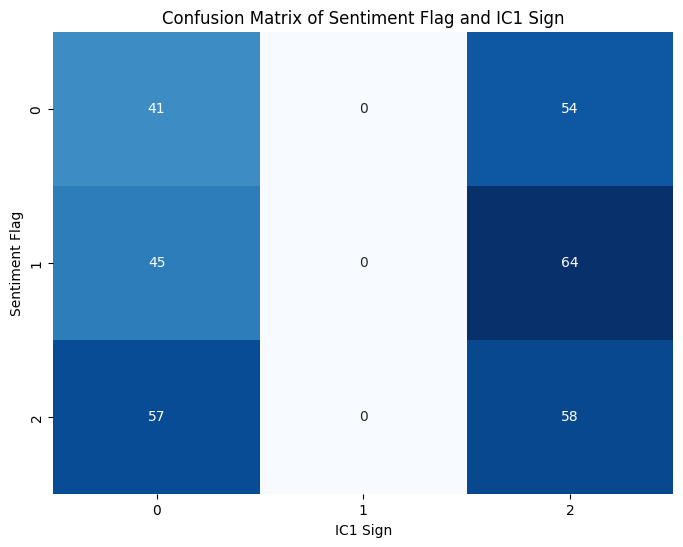

In [179]:
# Confusion matrix of sentiment_flag and the sign of IC 1
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the sign of the first independent component
x['IC1 Sign'] = np.sign(pipe.transform(x[spts])[:, 0])
# Create a confusion matrix
cm = confusion_matrix(x['Sentiment_Flag'], x['IC1 Sign'])
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix of Sentiment Flag and IC1 Sign')
plt.xlabel('IC1 Sign')
plt.ylabel('Sentiment Flag')

In [180]:
sentiment_pos_df = x[x['Sentiment_Flag'] == 1]
sentiment_0_df = x[x['Sentiment_Flag'] == 0]
sentiment_neg_df = x[x['Sentiment_Flag'] == -1]


Positive Sentiment Members: 115
Neutral Sentiment Members: 109
Negative Sentiment Members: 95


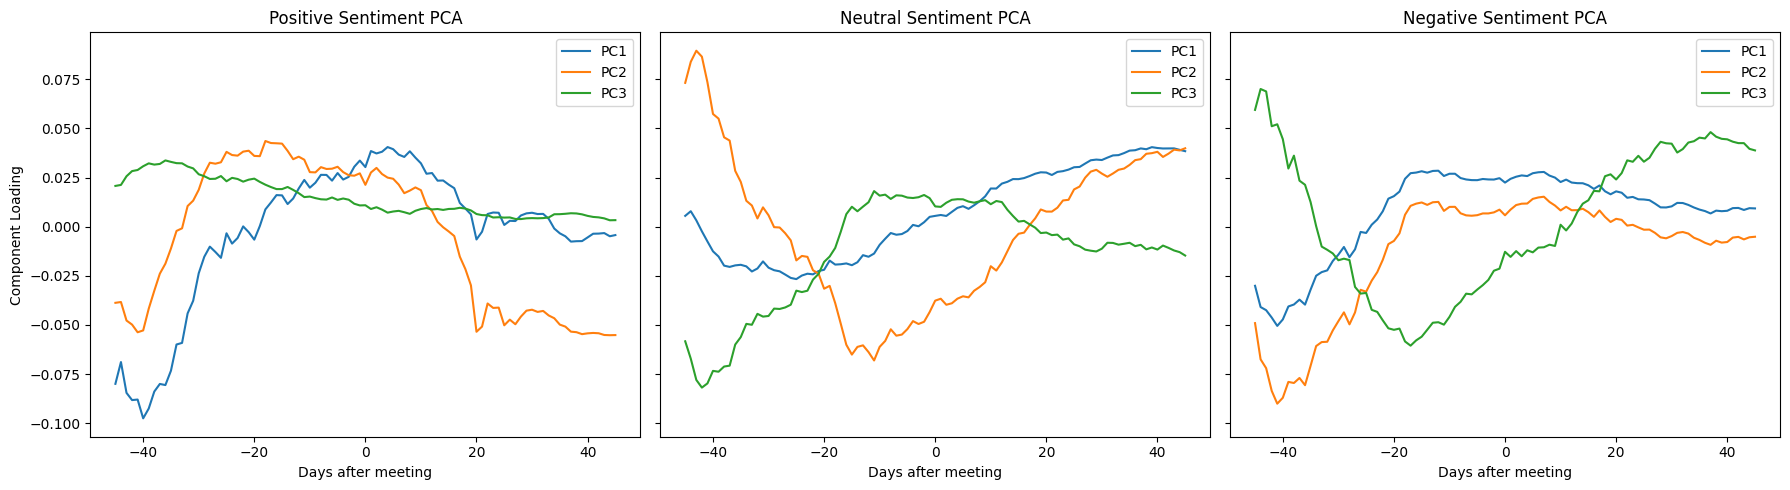

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assume spts has 90 features (e.g., days -45 to +44)
n_days = len(spts)
x_values = np.arange(n_days) - 45  # center around day 0

ica_0 = FastICA(n_components=3)
ica_pos = FastICA(n_components=3)
ica_neg = FastICA(n_components=3)

pip_pos = Pipeline([('scaler', scaler), ('ica', ica_pos)])
pip_0 = Pipeline([('scaler', scaler), ('ica', ica_0)])
pip_neg = Pipeline([('scaler', scaler), ('ica', ica_neg)])

# Fit PCA for each sentiment group
pca_pos = pip_pos.fit(sentiment_pos_df[spts])
pca_0 = pip_0.fit(sentiment_0_df[spts])
pca_neg = pip_neg.fit(sentiment_neg_df[spts])

# Extract top 3 components
components_pos = pca_pos.named_steps['ica'].components_[:3]
components_0 = pca_0.named_steps['ica'].components_[:3]
components_neg = pca_neg.named_steps['ica'].components_[:3]

# Plot them side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Positive
axs[0].plot(x_values, components_pos.T)
axs[0].set_title('Positive Sentiment PCA')
axs[0].set_xlabel('Days after meeting')
axs[0].set_ylabel('Component Loading')
axs[0].legend(['PC1', 'PC2', 'PC3'])

# Neutral
axs[1].plot(x_values, components_0.T)
axs[1].set_title('Neutral Sentiment PCA')
axs[1].set_xlabel('Days after meeting')
axs[1].legend(['PC1', 'PC2', 'PC3'])

# Negative
axs[2].plot(x_values, components_neg.T)
axs[2].set_title('Negative Sentiment PCA')
axs[2].set_xlabel('Days after meeting')
axs[2].legend(['PC1', 'PC2', 'PC3'])

#Print how many members in each IC
print("Positive Sentiment Members:", len(sentiment_pos_df))
print("Neutral Sentiment Members:", len(sentiment_0_df))
print("Negative Sentiment Members:", len(sentiment_neg_df))

plt.tight_layout()
plt.show()


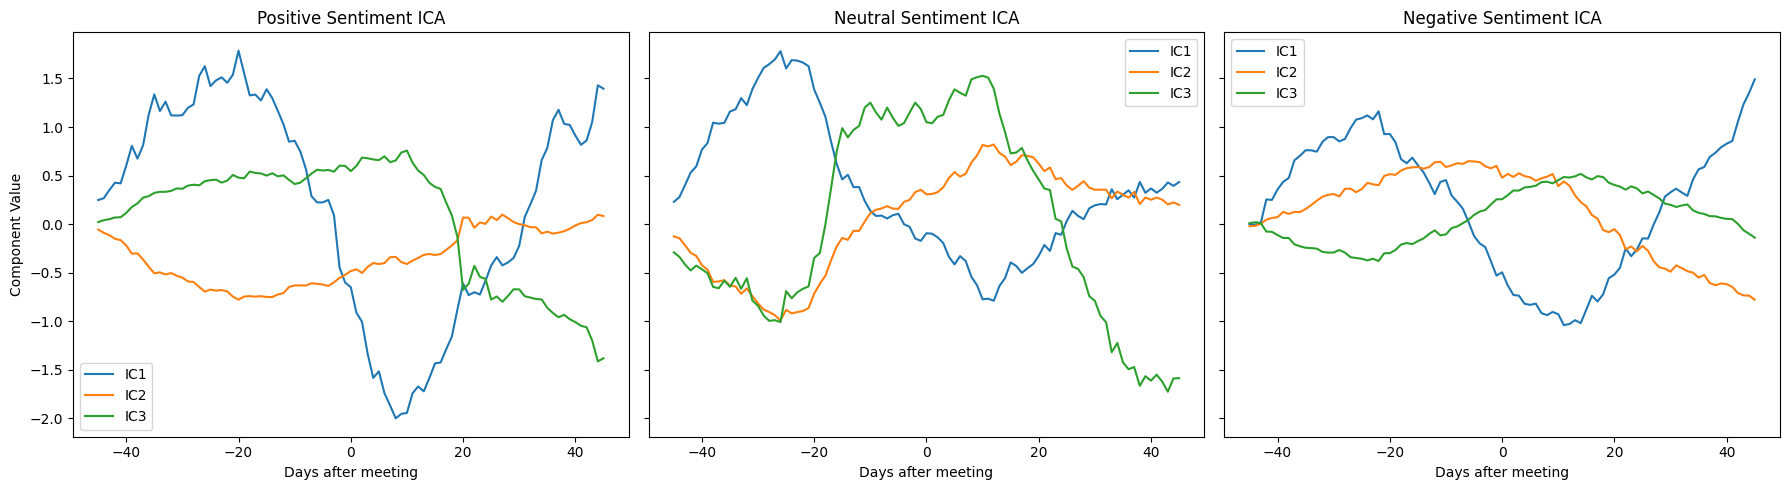

In [182]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

# ICA setup (number of components = at least 3)
n_components = 3
ica_pos = FastICA(n_components=n_components, random_state=42)
ica_0 = FastICA(n_components=n_components, random_state=42)
ica_neg = FastICA(n_components=n_components, random_state=42)

# Fit ICA to each sentiment group
ica_pos.fit(sentiment_pos_df[spts])
ica_0.fit(sentiment_0_df[spts])
ica_neg.fit(sentiment_neg_df[spts])

# Extract independent components
components_pos = ica_pos.components_
components_0 = ica_0.components_
components_neg = ica_neg.components_

# Setup x-axis centered around event (e.g., day 0)
n_days = len(spts)
x_values = np.arange(n_days) - 45  # adjust based on your data

# Plot them side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Positive
axs[0].plot(x_values, components_pos.T)
axs[0].set_title('Positive Sentiment ICA')
axs[0].set_xlabel('Days after meeting')
axs[0].set_ylabel('Component Value')
axs[0].legend(['IC1', 'IC2', 'IC3'])

# Neutral
axs[1].plot(x_values, components_0.T)
axs[1].set_title('Neutral Sentiment ICA')
axs[1].set_xlabel('Days after meeting')
axs[1].legend(['IC1', 'IC2', 'IC3'])

# Negative
axs[2].plot(x_values, components_neg.T)
axs[2].set_title('Negative Sentiment ICA')
axs[2].set_xlabel('Days after meeting')
axs[2].legend(['IC1', 'IC2', 'IC3'])

plt.tight_layout()
plt.show()

        Date  Sentiment_Flag       PC1       PC2       PC3
1 1976-04-20               1 -0.001000  0.014421 -0.009962
2 1976-05-18               1  0.012279  0.012818  0.016549
4 1976-07-20               0 -0.025416  0.018005 -0.009255
5 1976-08-17              -1  0.014169 -0.037677  0.001910
6 1976-09-21               1 -0.003087  0.034289 -0.052632


/Users/amanrana/Documents/Projects/Event_Studies_w_CA/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FastICA was fitted without feature names
  warnings.warn(


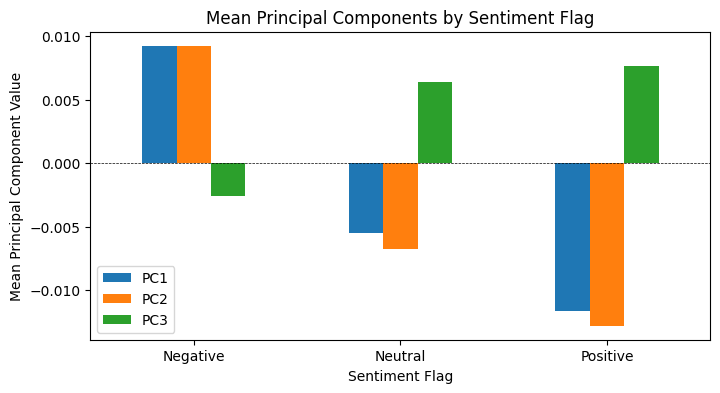

In [183]:
# -----------------
# Create a time-series DataFrame with date, sentiment, and PC1-3

# Perform the transform
pcs = ica.transform(x[spts])  # shape: (n_rows, n_components)

# Add pcs to x
x['IC1'] = pcs[:, 0]
x['IC2'] = pcs[:, 1]
x['IC3'] = pcs[:, 2]

# Construct a DataFrame of the first 3 PCs alongside "Date" and "Sentiment_Flag"
df_pcs = pd.DataFrame({
    'Date': x['Date'],
    'Sentiment_Flag': x['Sentiment_Flag'],
    'PC1': pcs[:, 0],
    'PC2': pcs[:, 1],
    'PC3': pcs[:, 2],
}, index=x.index)  # keep the same index as x, if desired

print(df_pcs.head())

#PLot Mean PCs by sentiment flag

# Suppose Sentiment_Flag is in {-1, 0, 1}
mapping = { -1: 'Negative', 0: 'Neutral', 1: 'Positive' }

# Compute the mean PCs, grouped by the numeric sentiment
mean_pcs = df_pcs.groupby('Sentiment_Flag')[['PC1', 'PC2', 'PC3']].mean()

# Rename the resulting rows to 'Negative', 'Neutral', 'Positive'
mean_pcs.rename(index=mapping, inplace=True)

# Reindex in the specific order you want
mean_pcs = mean_pcs.reindex(['Negative', 'Neutral', 'Positive'])

# Now do the bar plot
ax = mean_pcs.plot(kind='bar', figsize=(8, 4))
ax.set_title('Mean Principal Components by Sentiment Flag')
ax.set_xlabel('Sentiment Flag')
ax.set_ylabel('Mean Principal Component Value')
ax.legend(['PC1', 'PC2', 'PC3'])
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xticks(rotation=0)
plt.show()

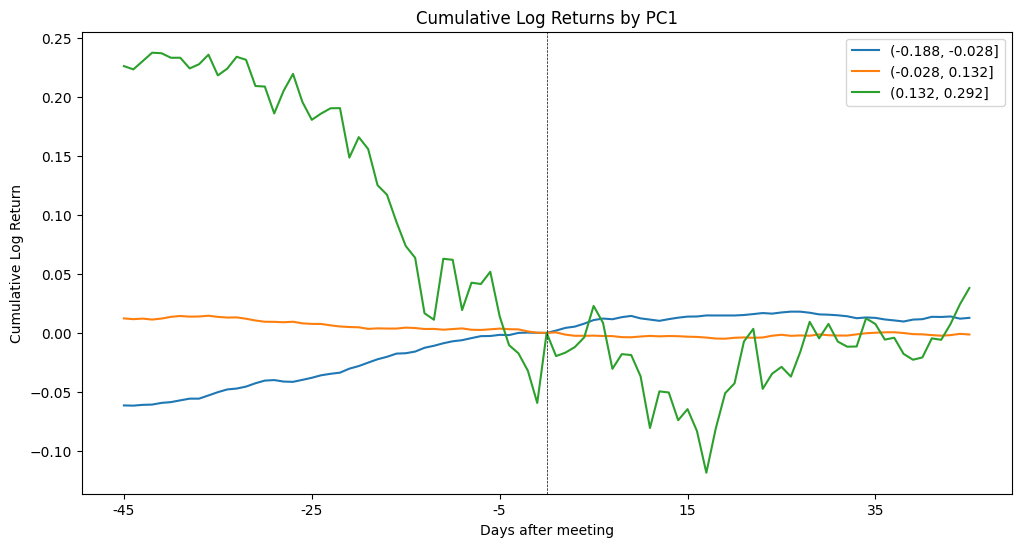

In [184]:
#Group by PC1, plot the event
# Group by PC1 and calculate the mean
# Create bins for PC1
x['PC1_bin'] = pd.cut(x['IC1'], bins=3)
zero_value = x.groupby('PC1_bin')[['0']].mean()
y = x.groupby('PC1_bin')[spts].mean()
y = y.subtract(zero_value['0'], axis=0)
# Plot the cumulative log returns, a line for each row
y.T.plot(figsize=(12, 6))
plt.title('Cumulative Log Returns by PC1')
plt.xlabel('Days after meeting')
plt.ylabel('Cumulative Log Return')
# Line axvline at 0
plt.axvline(45, color='black', linewidth=0.5, linestyle='--')
# Legend on the RHS
plt.legend()
plt.show()


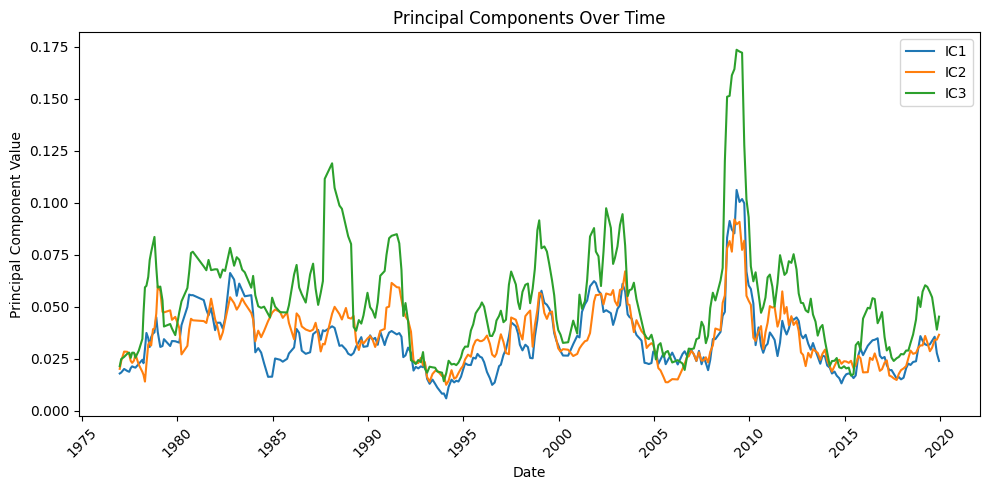

In [185]:
#Timeseries of the PCs
plt.figure(figsize=(10, 5))
# plt.plot(x['Date'], x['PC1'].abs().rolling(window=8).mean(), label='PC1')
# plt.plot(x['Date'], x['PC2'].abs().rolling(window=8).mean(), label='PC2')
# plt.plot(x['Date'], x['PC3'].abs().rolling(window=8).mean(), label='PC3')
plt.plot(x['Date'], x['IC1'].abs().rolling(window=8).mean(), label='IC1')
plt.plot(x['Date'], x['IC2'].abs().rolling(window=8).mean(), label='IC2')
plt.plot(x['Date'], x['IC3'].abs().rolling(window=8).mean(), label='IC3')
plt.title('Principal Components Over Time')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Correlation of PC laodings with macrofactos can tell us which factors drive more information injection.

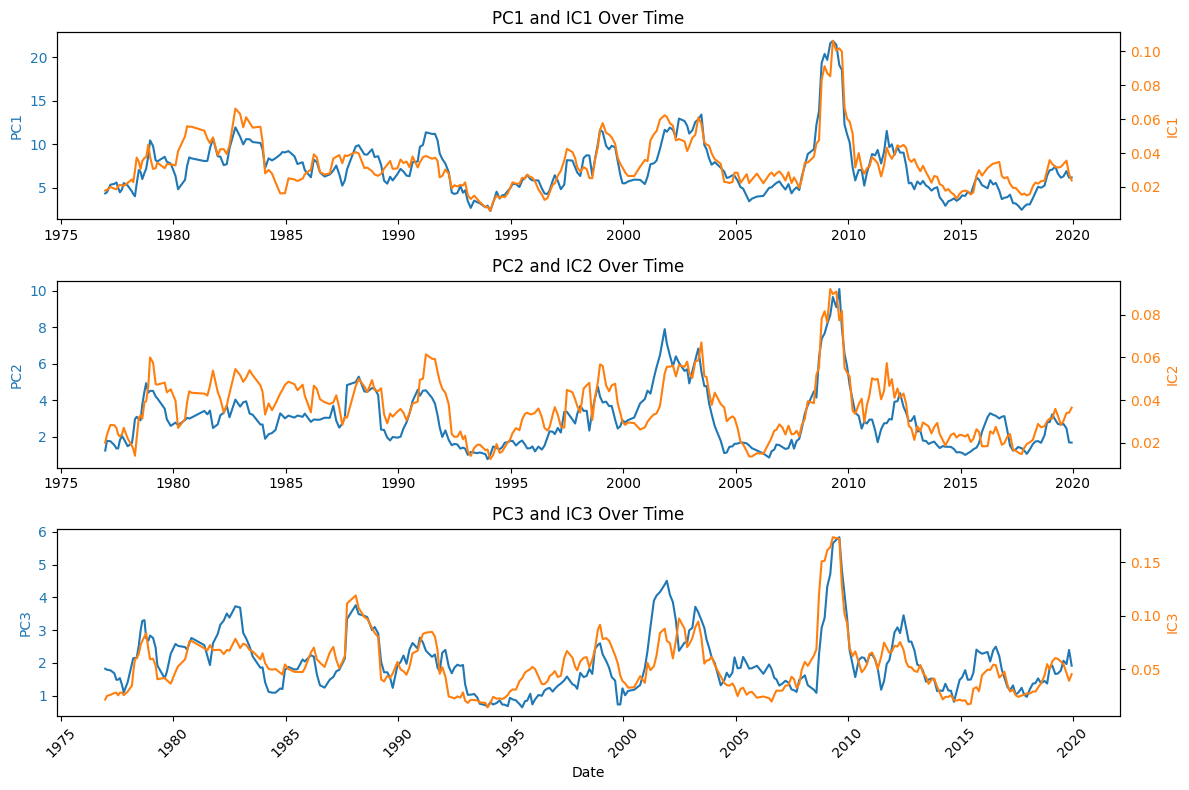

In [186]:
plt.figure(figsize=(12, 8))

# PC1 and IC1
ax1 = plt.subplot(3, 1, 1)
ax1.plot(x['Date'], x['PC1'].abs().rolling(window=8).mean(), label='PC1', color='tab:blue')
ax1.set_ylabel('PC1', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1b = ax1.twinx()
ax1b.plot(x['Date'], x['IC1'].abs().rolling(window=8).mean(), label='IC1', color='tab:orange')
ax1b.set_ylabel('IC1', color='tab:orange')
ax1b.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_title('PC1 and IC1 Over Time')

# PC2 and IC2
ax2 = plt.subplot(3, 1, 2)
ax2.plot(x['Date'], x['PC2'].abs().rolling(window=8).mean(), label='PC2', color='tab:blue')
ax2.set_ylabel('PC2', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2b = ax2.twinx()
ax2b.plot(x['Date'], x['IC2'].abs().rolling(window=8).mean(), label='IC2', color='tab:orange')
ax2b.set_ylabel('IC2', color='tab:orange')
ax2b.tick_params(axis='y', labelcolor='tab:orange')

ax2.set_title('PC2 and IC2 Over Time')

# PC3 and IC3
ax3 = plt.subplot(3, 1, 3)
ax3.plot(x['Date'], x['PC3'].abs().rolling(window=8).mean(), label='PC3', color='tab:blue')
ax3.set_ylabel('PC3', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')
ax3.set_xlabel('Date')
ax3.tick_params(axis='x', rotation=45)

ax3b = ax3.twinx()
ax3b.plot(x['Date'], x['IC3'].abs().rolling(window=8).mean(), label='IC3', color='tab:orange')
ax3b.set_ylabel('IC3', color='tab:orange')
ax3b.tick_params(axis='y', labelcolor='tab:orange')

ax3.set_title('PC3 and IC3 Over Time')

plt.tight_layout()
plt.show()